# **Workshop 2D Robot Kinematic and Dynamic**

In [5]:
import math

from numpy.matlib import matrix,rand,zeros,ones,empty,eye
import numpy.matlib as M

import numpy as np
import numpy.matlib as ml
from numpy import linalg as LA
import matplotlib.pyplot as plt
import numpy.random as rnd
from matplotlib.patches import Ellipse, Circle

## **Scara Robot Kinematic**

### Ex1

EX1: write function for the inverse and forward kinematic (verify with S=[-70,-100] and length_arms=[100,70])

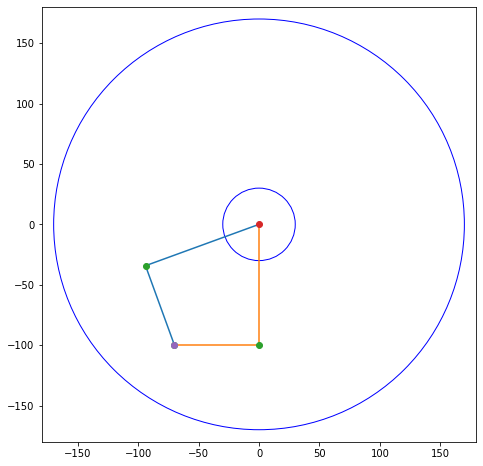

[-2.79224826  1.57079633]
[-1.57079633 -1.57079633]


In [6]:
def ik1P(point,l): #1 point
    l0 = l[0]
    l1 = l[1]
    x = point[0]
    y = point[1]
    
    beta = np.arccos((-np.square(l0)-np.square(l1)+np.square(x)+np.square(y))/(2*l0*l1)) 
    alpha1 = np.arctan2(y,x)-np.arctan2(l1*np.sin(beta),l0+l1*np.cos(beta)) 
    alpha2 = np.arctan2(y,x)-np.arctan2(l1*np.sin(-beta),l0+l1*np.cos(-beta))
    
    sol1 = np.array([alpha1,beta])
    sol2 = np.array([alpha2,-beta])
    
    return sol1,sol2

def fk1P(q,l): # 1 point
    rP1 = np.array([l[0]*np.cos(q[0]), l[0]*np.sin(q[0])])
    rP2 = np.array([l[0]*np.cos(q[0])+l[1]*np.cos(q[0]+q[1]), l[0]*np.sin(q[0])+l[1]*np.sin(q[0]+q[1])])
    return rP1,rP2

#DATA SCARA KINEMATIC:
S = np.array([-70,-100])
l = np.array([100,70]) #lenght arms

q1,q2 = ik1P(S,l)

rP11,rP21 = fk1P(q1,l)
rP12,rP22 = fk1P(q2,l)

c1 = Circle(xy=[0,0], radius=l[1]-l[0],color='b', fill=False)
c2 = Circle(xy=[0,0], radius=l[1]+l[0],color='b',fill=False)

fig = plt.figure(1,figsize=(8,8))
ax = fig.add_subplot(111, aspect='equal')
ax.add_artist(c1)
ax.add_artist(c2)

ax.plot([0,rP11[0],rP21[0]],[0,rP11[1],rP21[1]])
ax.plot([0,rP12[0],rP22[0]],[0,rP12[1],rP22[1]])
ax.plot([rP11[0],rP21[0],rP12[0]],[rP11[1],rP21[1],rP12[1]],'o')
ax.plot([0],[0],'o')
ax.plot(S[0],S[1],'o')
lim = l[0]+l[1]+10
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)


plt.show()
print(q1)
print(q2)

### Ex2

EX2: Write a function for the calculation of the jacobian (verify with S=[-70,-100] and length_arms=[100,70])

In [7]:
def jacobian_x(x, l):
    sol1,sol2 = ik1P(x,l)
    jacobian_matrix = jacobian_q(sol1,l)
    return jacobian_matrix

def jacobian_q(q, l):
  q1 = q[0]
  q2 = q[1]
  l1 = l[0]
  l2 = l[1]

  jacobian = np.array([[-l1*np.sin(q1)-l2*np.sin(q1+q2),-l2*np.sin(q1+q2)],
                       [ l1*np.cos(q1)+l2*np.cos(q1+q2), l2*np.cos(q1+q2)]])
  return jacobian

#DATA SCARA KINEMATIC:
S = np.array([-70,-100])
l = np.array([100,70]) #lenght arms

q1,q2 = ik1P(S,l)
jacobian1 = jacobian_q(q1,l)
jacobian2 = jacobian_x(S,l)

print(jacobian1)
print(jacobian2)

[[100.          65.77181208]
 [-70.          23.95973154]]
[[100.          65.77181208]
 [-70.          23.95973154]]


### Ex3

EX.3 Considering the following 5 trajectories from point1 to point2, calculate the manipulability of each trajectories and chose the best one.

The trajectory with higher manipolability is: 3


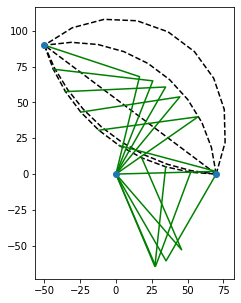

In [9]:
def ik2P(x,l): # n point
    l0 = ml.repmat(l[0],np.shape([x])[1],1)
    l1 = ml.repmat(l[1],np.shape([x])[1],1)

    
    beta = np.arccos((-np.square(l0)-np.square(l1)+np.square(x[:,0:1])+np.square(x[:,1:2]))/(2*l0*l1))
    alpha1  = np.arctan2(x[:,1:2],x[:,0:1])-np.arctan2(l1*np.sin(beta),l0+l1*np.cos(beta))
    alpha2  = np.arctan2(x[:,1:2],x[:,0:1])-np.arctan2(l1*np.sin(-beta),l0+l1*np.cos(-beta))
   
    sol1 = np.concatenate((np.transpose(alpha1), np.transpose(beta)), axis=0)
    sol2 = np.concatenate((np.transpose(alpha2),np.transpose(-beta)), axis=0)
    return sol1,sol2

def fk2P(q,l): # n point
    rP1 = np.array([l[0]*np.cos(q[0,:]), l[0]*np.sin(q[0,:])])
    rP2 = np.array([l[0]*np.cos(q[0,:])+l[1]*np.cos(q[0,:]+q[1,:]), l[0]*np.sin(q[0,:])+l[1]*np.sin(q[0,:]+q[1,:])])
    return rP1,rP2
    
def utility_fun(q,l):
  manipulability = 0 
  for i in q:
    jacobian = jacobian_q(i,l)
    manipulability += np.sqrt(np.linalg.det(np.dot(jacobian,jacobian.T)))
  return manipulability


def path1(A,B):
  x = np.linspace(A[0],B[0],10)
  m = (B[1]-A[1])/(B[0]-A[0])
  y = B[1]+m*(x-B[0])
  return x,y

def path2(A,B,x_center):
  m = -1/((A[1]-B[1])/(A[0]-B[0]))
  C = np.array([(A[0]+B[0])/2,(A[1]+B[1])/2])
  q = C[1]-m*C[0]
  y_center = m*x_center+q 
  r = np.sqrt(np.square(A[0]-x_center)+np.square(A[1]-y_center))
  base = np.sqrt(np.square(A[0]-B[0])+np.square(A[1]-B[1]))/2

  A0 = [A[0]-x_center,A[1]-y_center]
  B0 = [B[0]-x_center,B[1]-y_center]


  if A0[1]<=0:
    acosA = -np.arccos(A0[0]/r)
  if A0[1]>0:
    acosA = np.arccos(A0[0]/r)

  if B0[1]<=0:
    acosB = -np.arccos(B0[0]/r)
  if B0[1]>0:
    acosB = np.arccos(B0[0]/r)
  
  angle_i = min(acosA,acosB)
  angle_f = max(acosA,acosB)
  
  x_obs = x_center + r*np.cos(np.linspace(angle_i, angle_f, num=10))
  y_obs = y_center + r*np.sin(np.linspace(angle_i, angle_f, num=10))
  return x_obs, y_obs 

#DATA
point1 = np.array([70,0])
point2 = np.array([-50,90])

#points trajectories:
x1,y1 = path1(point1,point2)
x2,y2= path2(point1,point2,0)
x3,y3= path2(point1,point2,70)
x4,y4= path2(point1,point2,-30)
x5,y5= path2(point1,point2,80)

l = np.array([70,70])

#inverse kinematic
q1, q = ik2P(np.transpose(np.vstack((x1,y1))),l)
q2, q = ik2P(np.transpose(np.vstack((x2,y2))),l)
q3, q = ik2P(np.transpose(np.vstack((x3,y3))),l)
q4, q = ik2P(np.transpose(np.vstack((x4,y4))),l)
q5, q = ik2P(np.transpose(np.vstack((x5,y5))),l)

#robot point
rP11, rP12 = fk2P(q1,l)
rP21, rP22 = fk2P(q2,l)
rP31, rP32 = fk2P(q3,l)
rP41, rP42 = fk2P(q4,l)
rP51, rP52 = fk2P(q5,l)

#Manipolability
man1 = utility_fun(q1,l)
man2 = utility_fun(q2,l)
man3 = utility_fun(q3,l)
man4 = utility_fun(q4,l)
man5 = utility_fun(q5,l)

x = [man1, man2, man3,man4,man5]
j = np.argsort(x)[-1]+1
print('The trajectory with higher manipolability is: %d' %(j))


fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111, aspect='equal')
ax.plot(x1,y1,'--k')
ax.plot(x2,y2,'--k')
ax.plot(x3,y3,'--k')
ax.plot(x4,y4,'--k')
ax.plot(x5,y5,'--k')
for i in range(10):
  ax.plot([0,(eval('rP%d1'% (j)))[0,i],(eval('rP%d2'% (j)))[0,i]],[0,(eval('rP%d1'% (j)))[1,i],(eval('rP%d2'% (j)))[1,i]],'g')
ax.plot([0,point1[0],point2[0]],[0,point1[1],point2[1]],'o')
plt.show()


### Ex4

EX4: Plot the Velocity Ellipses considering as trajectory the line y=0 (length_arms=[70,70])

[[-0.99665292  0.08174931]
 [-0.08174931 -0.99665292]]
[  536.48225746 21263.51774254]
angle 85.31087664956678
[[-0.81730531  0.57620486]
 [-0.57620486 -0.81730531]]
[2423.20981398 6701.79018602]
angle 54.815947194326775
[[ 1.000000e+00  6.123234e-17]
 [-6.123234e-17  1.000000e+00]]
[4.90000000e+03 7.34882294e-29]
angle 90.0
[[-0.81730531  0.57620486]
 [-0.57620486 -0.81730531]]
[2423.20981398 6701.79018602]
angle 54.815947194326775
[[-0.99665292  0.08174931]
 [-0.08174931 -0.99665292]]
[  536.48225746 21263.51774254]
angle 85.3108766495668


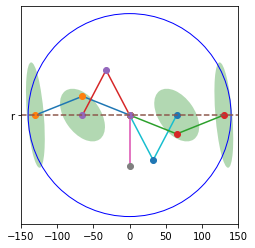

In [10]:
def ik2P(x,l): # n point
    l0 = ml.repmat(l[0],np.shape([x])[1],1)
    l1 = ml.repmat(l[1],np.shape([x])[1],1)

    
    beta = np.arccos((-np.square(l0)-np.square(l1)+np.square(x[:,0:1])+np.square(x[:,1:2]))/(2*l0*l1))
    alpha1  = np.arctan2(x[:,1:2],x[:,0:1])-np.arctan2(l1*np.sin(beta),l0+l1*np.cos(beta))
    alpha2  = np.arctan2(x[:,1:2],x[:,0:1])-np.arctan2(l1*np.sin(-beta),l0+l1*np.cos(-beta))
   
    sol1 = np.concatenate((np.transpose(alpha1), np.transpose(beta)), axis=0)
    sol2 = np.concatenate((np.transpose(alpha2),np.transpose(-beta)), axis=0)
    return sol1,sol2

def fk2P(q,l): # n point
    rP1 = np.array([l[0]*np.cos(q[0,:]), l[0]*np.sin(q[0,:])])
    rP2 = np.array([l[0]*np.cos(q[0,:])+l[1]*np.cos(q[0,:]+q[1,:]), l[0]*np.sin(q[0,:])+l[1]*np.sin(q[0,:]+q[1,:])])
    return rP1,rP2
    
def plot_ellipses(q,l):
  jacobian = jacobian_q(q,l)
  w, v = LA.eig(np.dot(jacobian,jacobian.T))
  print(v)
  print(w)

  rot_angle = np.arccos( np.dot( [1,0], v[:,1] ) )*180/np.pi
  print('angle',rot_angle)

  EE_pose = [l[0]*np.cos(q[0])+l[1]*np.cos(q[0]+q[1]),l[0]*np.sin(q[0])+l[1]*np.sin(q[0]+q[1])]
  e = Ellipse(xy=EE_pose, width=np.sqrt(w[1]), height=np.sqrt(w[0]), angle=-rot_angle)
  e.set_clip_box(ax.bbox)
  e.set_alpha(0.3)
  e.set_facecolor('g')
  return e

def plot_scara(rP1,rP2):
  ax.plot([0,rP1[0],rP2[0]],[0,rP1[1],rP2[1]])
  ax.plot([rP1[0],rP2[0]],[rP1[1],rP2[1]],'o')
  ax.plot([0],[0],'o')
  lim = l[0]+l[1]+10
  ax.set_xlim(-lim, lim)
  ax.set_ylim(-lim, lim)
  return ax

def plot_workspace(l):
  c1 = Circle(xy=[0,0], radius=l[1]-l[0],color='b', fill=False)
  c2 = Circle(xy=[0,0], radius=l[1]+l[0],color='b',fill=False)
  ax.add_artist(c1)
  ax.add_artist(c2)

  return ax

def line(x):
  y = np.zeros(np.shape(x))
  return y

#Data
l = np.array([70,70])
points = np.transpose(np.array([np.linspace(-130,130,5),line(np.linspace(-130,130,5))]))

x_line = np.linspace(-150,150,1000)
y_line = line(x_line)

q1,q2 = ik2P(points,l)
rP1,rP2 = fk2P(q1,l)

fig = plt.figure(2)
ax = fig.add_subplot(111, aspect='equal')
for i in range(np.shape(q1)[1]):
  e = plot_ellipses(q1[:,i],l)
  ax.add_artist(e)
  plot_scara(rP1[:,i],rP2[:,i])
plot_workspace(l)
ax.plot(x_line,y_line, '--','r')
plt.show()

## **Scara Robot Dynamic**

### Ex1

EX1. Solve the inverse dynamic problem to obtain the torques during the movement of the gripper along a line from 𝑆𝑖=[0.2,0.5] to 𝑆𝑓=[−0.5,0.2].
Consider a cycloidal motion curve that takes 5s to complete the task under the following external forces, 𝐹𝑠𝑒=[1;1;0;0;0;0;0;0].

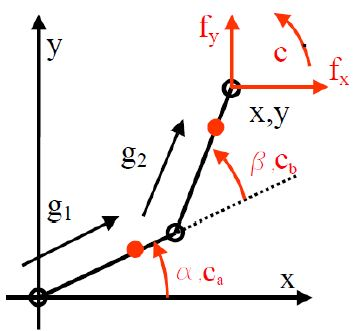

In [ ]:
def cycloidal(t,T,S0,dS):
    # cycloidal motion law
    """
    t time instant considered
    T time to comlete the movement
    S0 starting position
    dS total dispacement 
    
    assumption: Vini=Vfin=0"""

    ca=2*np.pi
    xpp=ca*np.sin(ca*t/T)*dS/T**2
    xp=(1-np.cos(ca*t/T))*dS/T
    x=S0+(t/T-np.sin(ca*t/T)/ca)*dS
    return x,xp,xpp

def exteded_jacobian(q,l,g1,g2):
    q1 = q[0]
    q2 = q[1]
    l1 = l[0]
    l2 = l[1]

    jacobian = np.array([[-l1*np.sin(q1)-l2*np.sin(q1+q2),-l2*np.sin(q1+q2)],
                        [ l1*np.cos(q1)+l2*np.cos(q1+q2), l2*np.cos(q1+q2)],
                        [-l1*np.sin(q1)-g2*np.sin(q1+q2),-g2*np.sin(q1+q2)],
                        [ l1*np.cos(q1)+g2*np.cos(q1+q2), g2*np.cos(q1+q2)],
                        [1,1],
                        [-g1*np.sin(q1),0],
                        [g1*np.cos(q1),0],
                        [1,0]])
    return jacobian

def exteded_jacobian_dot(q,q_dot,l,g1,g2):
    q1 = q[0]
    q2 = q[1]
    dq1 = q_dot[0]
    dq2 = q_dot[1]
    l1 = l[0]
    l2 = l[1]

    jacobian = np.array([[-dq1*l1*np.cos(q1)-(dq1+dq2)*l2*np.cos(q1+q2),-(dq1+dq2)*l2*np.cos(q1+q2)],
                         [-dq1*l1*np.sin(q1)-(dq1+dq2)*l2*np.sin(q1+q2),-(dq1+dq2)*l2*np.sin(q1+q2)],
                         [-dq1*l1*np.cos(q1)-(dq1+dq2)*g2*np.cos(q1+q2),-(dq1+dq2)*g2*np.cos(q1+q2)],
                         [-dq1*l1*np.sin(q1)-(dq1+dq2)*g2*np.sin(q1+q2),-(dq1+dq2)*g2*np.sin(q1+q2)],
                         [0,0],
                         [-dq1*g1*np.cos(q1),0],
                         [-dq1*g1*np.sin(q1),0],
                         [0,0]])
    return jacobian



#2D Robot moving a payload and subjected to a constant external force
#link1
l1 = 0.33 #m
g1 = 0.28 #m COM
m1 = 7.8 #kg
J1_z = 0.0565 #kg*m^2

#link2
l2 = 0.33 #m
g2 = 0.283 #m COM
m2 = 7 #kg
J2_z = 0.0565 #kg*m^2

#payload
M = 0.5 #kg

M_matrix = np.diag([M,M,m2,m2,(J1_z+J2_z),m1,m1,J1_z])

#Trajectory data
T = 5 #total movement time 
n = 100 # of points of the Mot.Law
dT = T/(n-1)


Si=np.array([0.2, 0.5]) #start point
Sf=np.array([-0.5, 0.2]) #end point

dS=Sf-Si
l = np.array([0.33,0.33])

tt = np.zeros((n))
x = np.zeros((n))
xv = np.zeros((n))
xa = np.zeros((n))
y = np.zeros((n))
yv = np.zeros((n))
ya = np.zeros((n))

Fee = np.zeros([8,])
Fee[0] = 1
Fee[1] = 1



for i in range(n):  
    t=(i)*dT #time between 0 and T with dT sampling time
    tt[i]=t
    x[i],xv[i],xa[i]=cycloidal(t,T,Si[0],Sf[0]-Si[0])
    y[i],yv[i],ya[i]=cycloidal(t,T,Si[1],Sf[1]-Si[1])



X = np.transpose(np.vstack((x,y)))
Xp = np.transpose(np.vstack((xv,yv)))
Xpp = np.transpose(np.vstack((xa,ya)))

plt.figure()
fig, axs = plt.subplots((3))
axs[0].plot(tt,x,'b',tt,y,'r')
axs[0].set(ylabel='Position')
axs[1].plot(tt,xv,'b',tt,yv,'r')
axs[1].set(ylabel='Speed')
axs[2].plot(tt,xa,'b',tt,ya,'r')
axs[2].set(xlabel='time',ylabel='Acceleration')
plt.show()

q1,q2 = ik2P(X,l)

rp1,rp2 = fk2P(q1,l)

q1_d = np.copy(q1)
q1_dd = np.copy(q1)
torque = np.copy(q1)

for j in range(np.shape(q1)[1]):
  J = exteded_jacobian(q1[:,j],l,g1,g2)[:2,:] 
  q1_d[:,j] = np.dot(np.linalg.inv(J),Xp[j,:])
  J_dot = exteded_jacobian_dot(q1[:,j],q1_d[:,j],l,g1,g2)[:2,:]
  q1_dd[:,j] = np.dot(np.linalg.inv(J),Xpp[j,:]-np.dot(J_dot,q1_d[:,j]))
  J_ext = exteded_jacobian(q1[:,j],l,g1,g2)
  J_ext_dot = exteded_jacobian_dot(q1[:,j],q1_d[:,j],l,g1,g2)
  Acc = np.dot(J_ext_dot,q1_d[:,j]) + np.dot(J_ext,q1_dd[:,j])

  
  F_i = -np.dot(M_matrix,Acc)

  Fse = Fee + F_i
  torque[:,j] = -np.dot(J_ext.T,Fse)


plt.plot(torque[0,:])
plt.plot(torque[1,:])

plt.show